In [ ]:
"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #01 - Function Fitting

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using function fitting. Script 
reads in observations from a text file, creates a map with grid
points to be used for analysis, and plots the analysis as well as the
number of observations available for each grid point. The analysis
being performed is the Gilchrist and Cressman Solution from 1954.

[PUT MORE INFORMATION HERE - I.E., WHAT SPECIFIC THING IS BEING DONE]

"""
__author__    = "Jared W. Marquis"
__contact__   = "jared.marquis@und.edu"

__edited_by__ = "Joshua R. Nielsen"

In [ ]:
!pip install pandas

In [ ]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles
import pandas as pd                #pandas for reading in observations

In [ ]:
### Read in observations ###
ds = pd.read_csv('RAOBs_201903131200.txt', sep=",", names = ['Station', 'Latitude', 'Longitude', 'Height', 'Wind_dir', 'Wind_spd'])
lons = ds['Longitude']
lats = ds['Latitude']
hgts_500 = ds['Height']

In [ ]:
### Set constants ###
rho = 6371*1e5
phi_0 = 60*(np.pi/180)
lambda_0 = -115
map_scale = 1/(15e6)

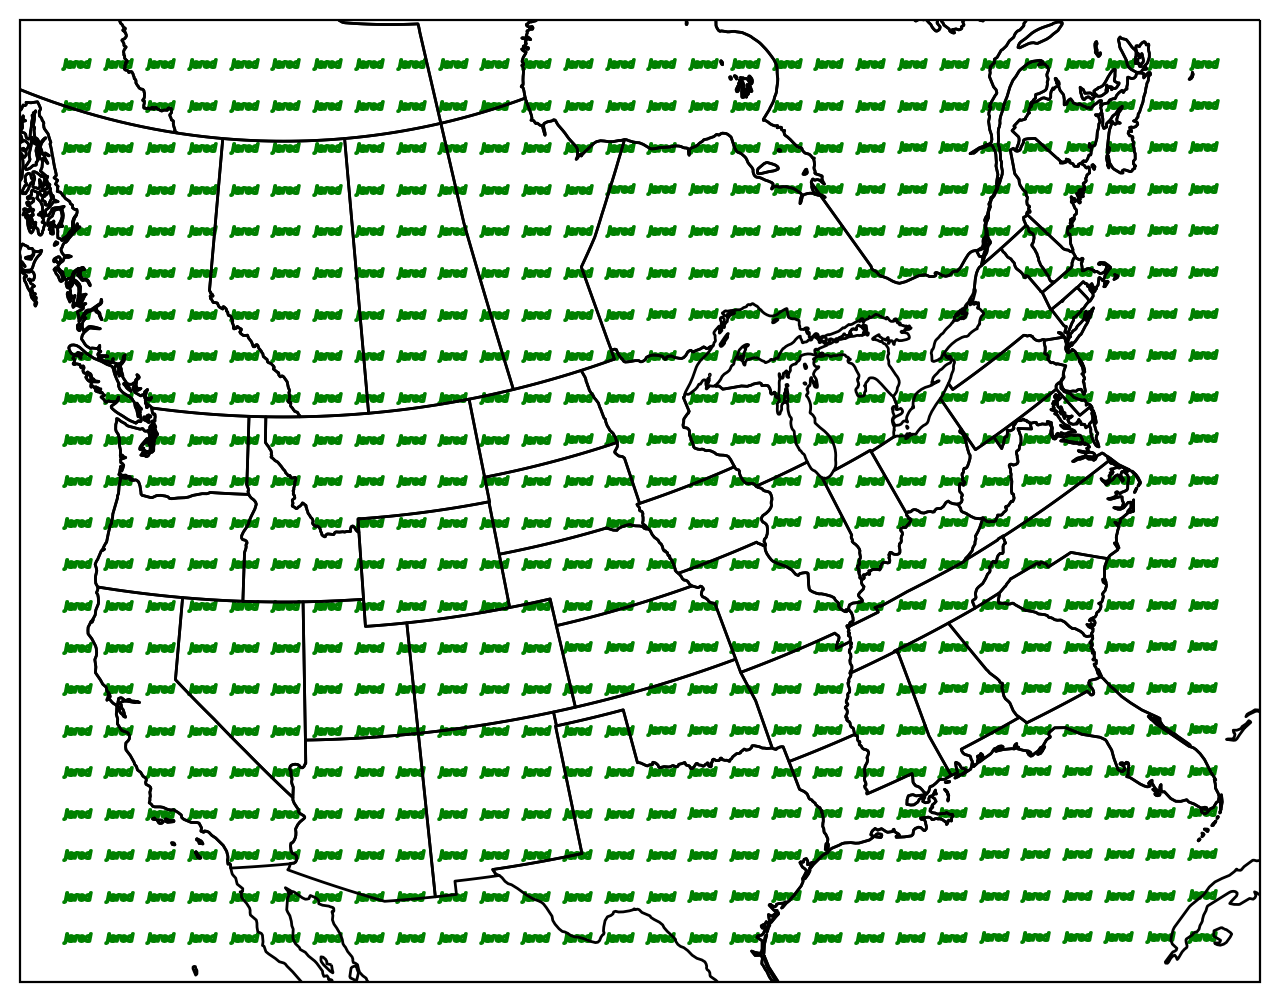

In [48]:
### Set up analysis map with a 22x28 rectangular grid of points ###
x_step = 18.90 + np.arange(22)*(1.27)
y_step = -6.30 + np.arange(28)*(1.27)
x_points, y_points = np.meshgrid(x_step, y_step)

### Convert x and y points to lat and lon for grid points ###
lon_grid = np.arctan(y_points/x_points)*(180/np.pi)+lambda_0
lat_grid = (180/np.pi)*((np.pi/2)-(2*np.arctan(np.sqrt((x_points/map_scale)**2+(y_points/map_scale)**2)/(rho*(1+np.sin(phi_0))))))

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

ax1.scatter(lon_grid.ravel(),lat_grid.ravel(),c='g',marker='$jared$',s=100,transform=ccrs.PlateCarree())

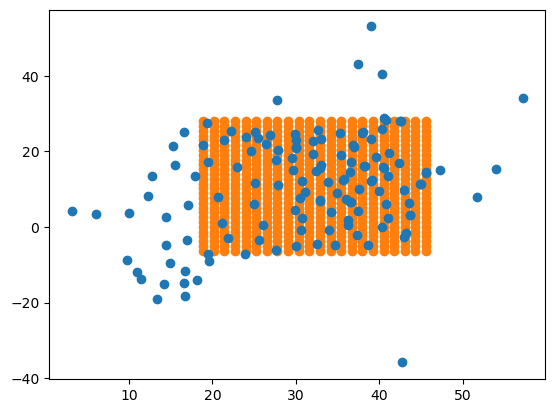

In [49]:
### convert obs lat/long to x,y (may want to plot on your analysis grid to verify)###
sigma = (1+np.sin(phi_0))/(1+np.sin((lats*(np.pi/180))))
r = rho*sigma*np.cos(lats*((np.pi/180)))*map_scale
x_obs = r*np.cos(((lons*(np.pi/180))-(lambda_0*(np.pi/180))))
y_obs = r*np.sin((lons*(np.pi/180))-lambda_0*(np.pi/180))

### Create plot to verify observations and grid points line up ###
plt.scatter(x_obs,y_obs,zorder = 10)
plt.scatter(x_points.ravel(),y_points.ravel())

In [55]:
### Perform 500mb geopotential height analyses using a second order 2-d polynomial with two ###
### radii of influence (10cm & 20cm) ###

x_grid=22
y_grid=28

### Create the matrices to find the analysis and number of obs at each grid point

rois = np.array([10, 20])
analysis_mat = np.empty((y_grid, x_grid, len(rois)))
n_obs_mat = np.empty((y_grid, x_grid, len(rois)))

for n_roi in range(len(rois)):
    roi = rois[n_roi]
    for i in range(len(x_points[0])):
        for j in range(len(x_points)):
            rel_x = x_points[j, i] - x_obs
            rel_y = y_points[j, i] - y_obs
            rel_rad = (rel_x ** 2 + rel_y**2)**0.5
            ind_rois = np.where(rel_rad<roi)[0]
            n_obs_mat[j, i, n_roi] = len(ind_rois)
        
            x_k = rel_x[ind_rois].values
            y_k = rel_y[ind_rois].values
            fo = hgts_500[ind_rois].values
            matrix_r = np.zeros((6,6))
            matrix_o = np.zeros(6)
        
        
            for k in range(len(x_k)):
                tmp1 = np.matrix([[1,x_k[k],y_k[k],x_k[k]**2,y_k[k]**2,x_k[k]*y_k[k]]])
                tmp2 = tmp1.T*tmp1
                matrix_r += tmp2
                matrix_o += np.array([fo[k],x_k[k]*fo[k],y_k[k]*fo[k],x_k[k]**2 * fo[k],y_k[k]**2 * fo[k],x_k[k]*y_k[k]*fo[k]])
        
            matrix_r = matrix_r/n_obs_mat[j, i, n_roi]
            matrix_o = matrix_o/n_obs_mat[j, i, n_roi]
            C = np.linalg.inv(matrix_r) * np.matrix(matrix_o).T
            analysis_mat[j, i, n_roi] = C[0,0]

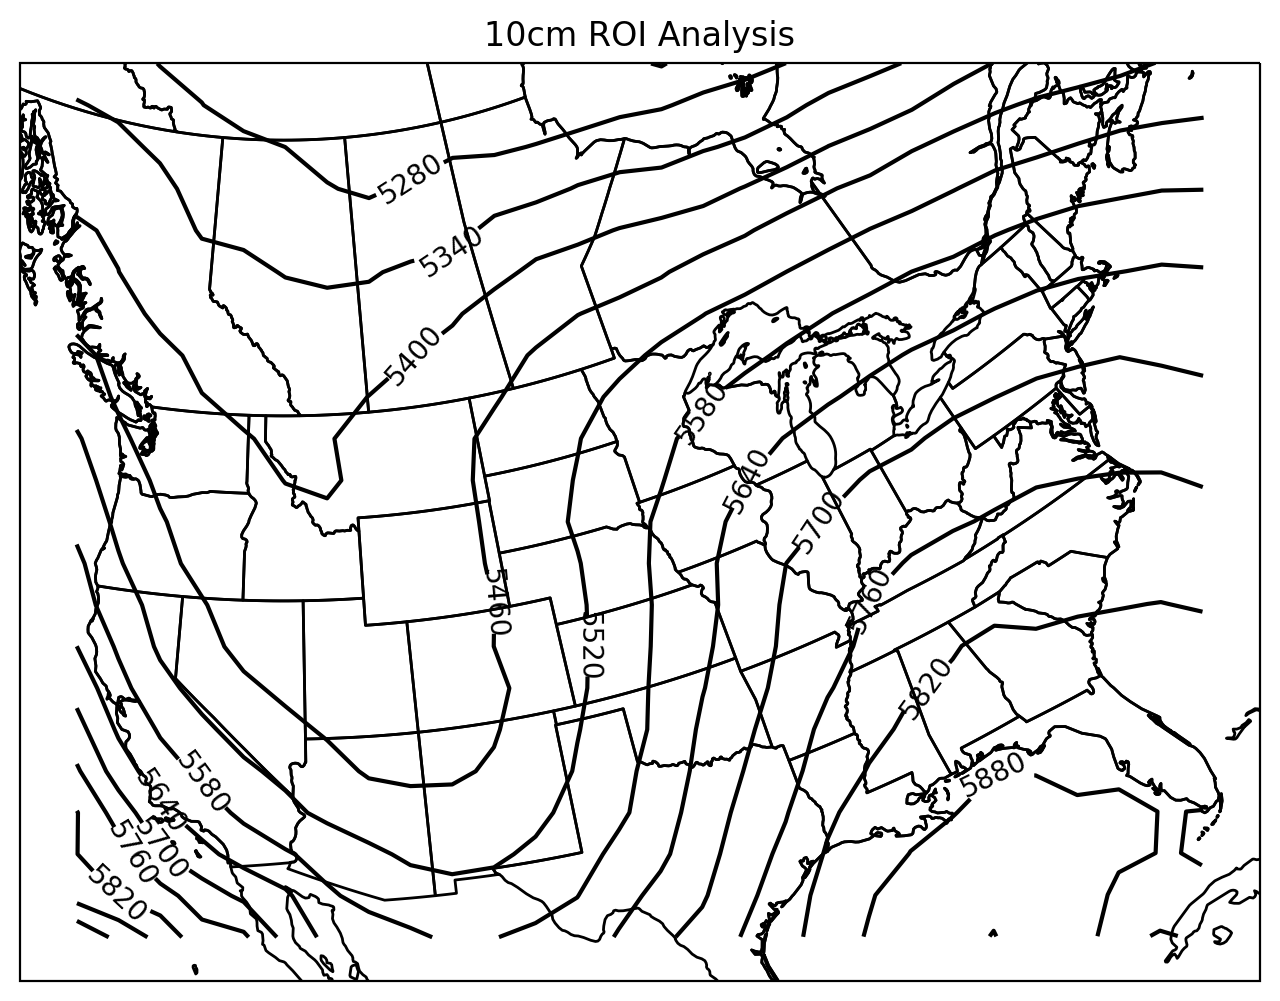

<Figure size 640x480 with 0 Axes>

In [56]:
### Plot 500mb analyses over a map ###
#convert analysis x,y to lat/lon#

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lon_grid,lat_grid,analysis_mat[:,:,0],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title ('10cm ROI Analysis')
plt.show()
plt.savefig('Analysis_10.png')

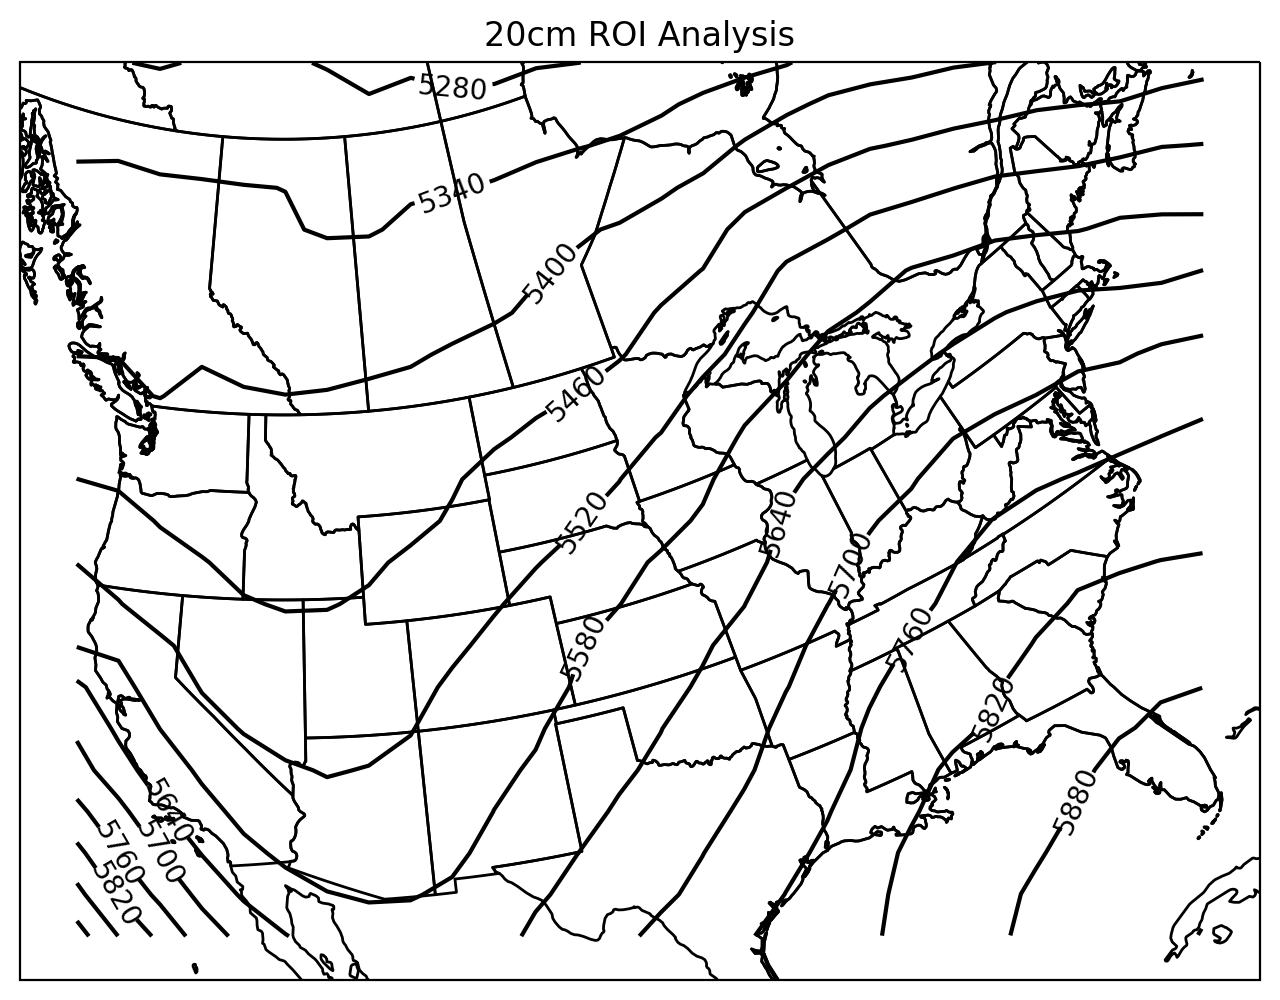

<Figure size 640x480 with 0 Axes>

In [57]:
### Plot 500mb analyses over a map ###
#convert analysis x,y to lat/lon#

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lon_grid,lat_grid,analysis_mat[:,:,1],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title ('20cm ROI Analysis')
plt.show()
plt.savefig('Analysis_20.png')

In [ ]:
### Plot number of observations available to polynomial fitting scheme for each grid point ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot number of observations (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lon_grid,lat_grid,n_obs_mat[:,:,0],colors='k',levels=np.arange(0,200,5),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,200,10))
plt.title('Number of Upper Air Observations per Grid Point with 10cm ROI')
plt.show()
plt.savefig('Number_Air_Obs_10.png')

In [ ]:
### Plot number of observations available to polynomial fitting scheme for each grid point ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot number of observations (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lon_grid,lat_grid,n_obs_mat[:,:,1],colors='k',levels=np.arange(0,200,5),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,200,10))
plt.title('Number of Upper Air Observations per Grid Point with 20cm ROI')
plt.show()
plt.savefig('Number_Air_Obs_20.png')

In [ ]:
### Store the analyses in text files ###

with open('HW1_Nielsen_roi_10_analyses.txt', 'w+') as f:
    f.write('grid_point, analysis_value\n')
    for i in range(len(x_points)):
        for j in range(len(x_points[0])):
            grid_point = str([i,j])
            analysis_val = str(analysis_mat[i,j,0])
            out_str = grid_point + ',' + analysis_val + '\n'
            f.write(out_str)
            
with open('HW1_Nielsen_roi_20_analyses.txt', 'w+') as f:
    f.write('grid_point, analysis_value\n')
    for i in range(len(x_points)):
        for j in range(len(x_points[0])):
            grid_point = str([i,j])
            analysis_val = str(analysis_mat[i,j,1])
            out_str = grid_point + ',' + analysis_val + '\n'
            f.write(out_str)

In [ ]:
### Store the number of observations available for each grid point in text files ###

with open('HW1_Nielsen_roi_10_number.txt', 'w+') as f:
    f.write('grid_point, number_available_obs\n')
    for i in range(len(x_points)):
        for j in range(len(x_points[0])):
            grid_point = str([i,j])
            n_obs = str(n_obs_mat[i,j,0])
            out_str = grid_point + ',' + n_obs + '\n'
            f.write(out_str)

with open('HW1_Nielsen_roi_20_number.txt', 'w+') as f:
    f.write('grid_point, number_available_obs\n')
    for i in range(len(x_points)):
        for j in range(len(x_points[0])):
            grid_point = str([i,j])
            n_obs = str(n_obs_mat[i,j,1])
            out_str = grid_point + ',' + n_obs + '\n'
            f.write(out_str)

In [ ]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.
    
    There is a trough over the Western US and a ridge over the Eastern US. The placement
    of the trough and ridge is different between the 2 analyses

2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
    
    Both analyses seem pretty smooth, but the 20 cm analysis appears to be a little more 
    smooth. The biggest difference I notice between the two analyses is the difference
    in the intensity of the trough on each map. On the 10 cm analysis, the trough 
    appears very deep with the contours pretty close together. On the 20 cm analysis,
    the trough is not as deep while the contours are spaced further apart. The ridge is
    also aligned more north-south compared to the ridge on the 10 cm map, which tilts
    back to the west. The reason the 20 cm map is more smooth is because there are more observations for
    each grid point.

3 - Run your program using a radius of influence of 6 cm (do not need to show).  
    Describe the results - do they look realistic?  If there are problems, what
    do you think might be causing them?
    
    When I run the code using a radius of influence of 6 cm, my program crashes saying 
    that the matrix is not invertible. I believe this is because the radius of influence
    is too small. I feel like this may be an issue with my code. If the results did 
    show, I think the results would not be realistic. I ran the code with the smallest
    ROI I could use (8 cm) and the features on the map were even more extreme than the 
    10 cm ROI. This shows me that the contours for an ROI of 6 cm would be even more 
    extreme and would probably cross into the border of unrealistic. For fun, I used an 
    ROI of 200 cm, and the contours produced were just straight lines.
    

4 - Suppose you ran this program with a small enough radius of influence that only one
    observation was available for determining a polynomial fit at a grid point.  Should
    you be able to perform the matrix inversion?  Why or why not?
    
    No you would not be able to perform the matrix inversion. The matrix would be
    singular because there would only be one observation available for each grid point
    and the determinant would be zero.
    
'''